Reduced number of features from 52 to 40


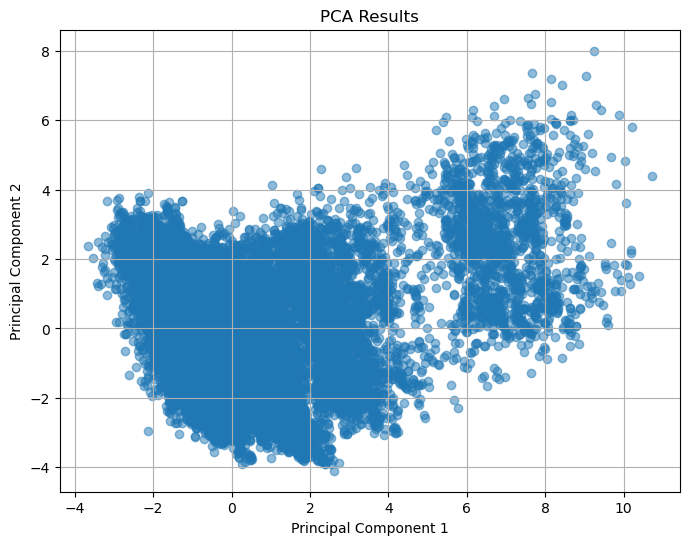

C:\Users\deepa\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


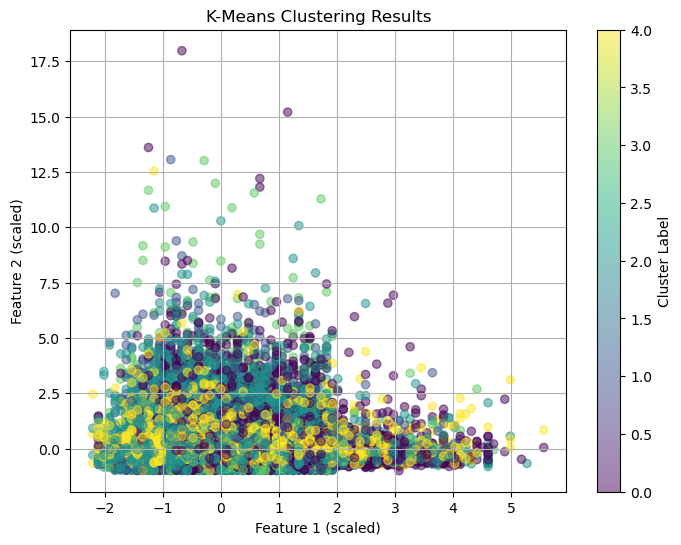

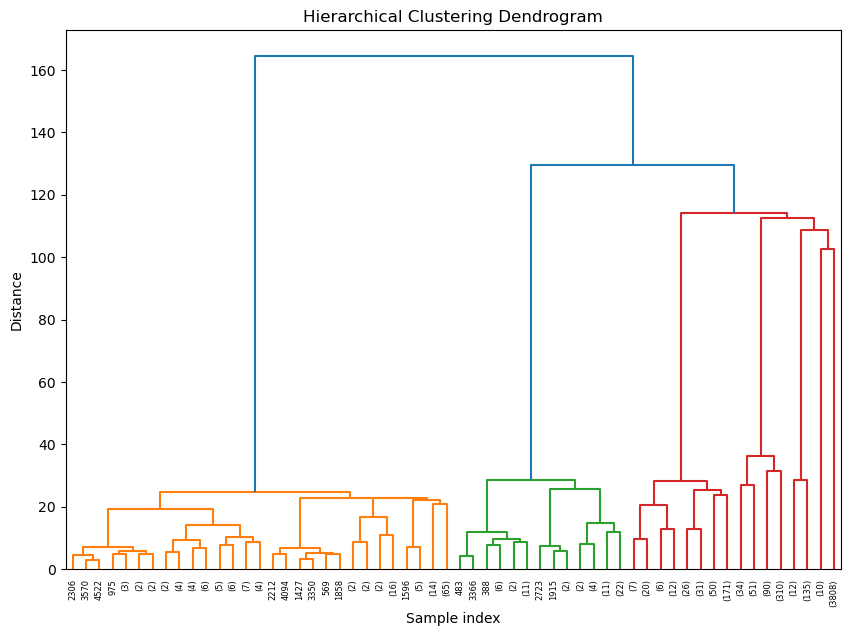

XGBoost with PCA Modelling: AUC = 0.75, Accuracy = 0.91
Random Forest with PCA Modelling: AUC = 0.71, Accuracy = 0.91
XGBoost with K-Cluster Modelling: AUC = 0.75, Accuracy = 0.92
Random Forest with K-Cluster Modelling: AUC = 0.73, Accuracy = 0.92
XGBoost with Hierarchical Cluster Modelling: AUC = 0.76, Accuracy = 0.92
Random Forest with Hierarchical Cluster Modelling: AUC = 0.73, Accuracy = 0.92


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

data = pd.read_csv('European_bank_marketing (1).csv')

data_reduced = data.drop(['emp.var.rate', 'nr.employed'], axis=1)
data_dummies = pd.get_dummies(data_reduced, drop_first=True)

X = data_dummies.drop('term_deposit', axis=1)
y = data_dummies['term_deposit']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)
print("Reduced number of features from", X_scaled.shape[1], "to", X_pca.shape[1])

# Plotting PCA results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Results')
plt.grid(True)
plt.show()

# K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_scaled)
X['cluster_kmeans'] = clusters_kmeans

# Plotting K-Means Clustering Results
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_kmeans, cmap='viridis', alpha=0.5)
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.title('K-Means Clustering Results')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

# Hierarchical clustering on a sample
sample_size = min(5000, len(X_scaled))  
X_sample = X_scaled[:sample_size]
h_clusters = linkage(X_sample, method='ward')
clusters_hier = fcluster(h_clusters, 5, criterion='maxclust')
X['cluster_hier'] = np.append(clusters_hier, [1]*(len(X)-sample_size))

# Plotting Hierarchical Clustering Dendrogram
plt.figure(figsize=(10, 7))
dendrogram(h_clusters, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

# Combine PCA components into the original dataset for modeling
X_with_pca = pd.concat([data_dummies.drop('term_deposit', axis=1), pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])], axis=1)

# Create datasets for K-Means and Hierarchical Clustering
X_with_kmeans = X.drop(columns=[col for col in X if col.startswith('PC') or col.startswith('cluster_hier')], axis=1)
X_with_hier = X.drop(columns=[col for col in X if col.startswith('PC') or col.startswith('cluster_kmeans')], axis=1)

def fit_evaluate_models(X, y, technique_name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    xgb_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)

    models = [xgb_model, rf_model]
    model_names = ['XGBoost', 'Random Forest']
    for model, name in zip(models, model_names):
        y_pred = model.predict(X_test)
        auc = roc_auc_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)
        
        print(f"{name} with {technique_name}: AUC = {auc:.2f}, Accuracy = {acc:.2f}")

# Evaluate models using the dataset with PCA components
fit_evaluate_models(X_with_pca, y, "PCA Modelling")

# Evaluate models using the dataset with K-Means clusters
fit_evaluate_models(X_with_kmeans, y, "K-Cluster Modelling")

# Evaluate models using the dataset with Hierarchical clusters
fit_evaluate_models(X_with_hier, y, "Hierarchical Cluster Modelling")
